In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os
from PIL import Image
import random
import matplotlib
from matplotlib.patches import Rectangle,Circle,Polygon
import matplotlib.colors as mcolors

from google import genai

import LLM_images as llm

/opt/anaconda3/lib/python3.12/site-packages/pydantic/_internal/_fields.py:184: UserWarning: Field name "name" shadows an attribute in parent "Operation"; 
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/pydantic/_internal/_fields.py:184: UserWarning: Field name "metadata" shadows an attribute in parent "Operation"; 
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/pydantic/_internal/_fields.py:184: UserWarning: Field name "done" shadows an attribute in parent "Operation"; 
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/pydantic/_internal/_fields.py:184: UserWarning: Field name "error" shadows an attribute in parent "Operation"; 
  warnings.warn(


In [57]:
from LLM_images import get_response

In [5]:
help(llm)

Help on module LLM_images:

NAME
    LLM_images

FUNCTIONS
    distance_formula(coord1, coord2)
        Calculate distance given two tuples/coordinate points

    generate_circle(r=0.3)
        Generates circle; radius can be varied

    generate_coord()
        Outputs a tuple/coordinate point

    generate_image(verb=False, max=5, l1=0.3, l2=0.18, path='/Users/zainabsiddiqui/Downloads/Data_Problems/LLM_Project/Data')
        Fully generates image with random assortment of shapes & automatically saves figure; descriptive statement can be generated; shape sizes can be adjusted

    generate_rectangle(w=0.5, h=0.35)
        Generates rectangle; width/height can be varied

    generate_triangle()
        Generates triangle

    get_response(image_path, show=True, model='gemma-3-27b-it', REQUEST='Identify and count the shapes in this image')

    is_triangle(coord1, coord2, coord3)
        Test if real triangle based on 3 points; Boolean output

    multiple_shapes(ax, max=5, limit1=0.5, 

In [7]:
data_dir = "/Users/zainabsiddiqui/Downloads/Data_Problems/LLM_Project/Data"

In [9]:
client = genai.Client()

In [11]:
responses=pd.DataFrame(columns=["pic_id","response","score","notes"])

In [109]:
def avg(l):
    for ind,tup in enumerate(l):
        if isinstance(tup, tuple):
            x,y = tup
            l[ind] = min(x,y)/max(x,y)
    return round(sum(l)/len(l),4)

In [ ]:
def weighted_score(predicted, expected):
    shapes = set(predicted.keys()).union(expected.keys())
    total_expected = sum(expected.values())
    if total_expected == 0:
        return 0.0
    weighted_scores = []
    for shape in shapes:
        pred = predicted.get(shape, 0)
        exp = expected.get(shape, 0)
        if exp == 0 and pred > 0:
            shape_score = 0  # hallucinated shape
            weight = 0  # or penalize?
        else:
            shape_score = min(pred, exp) / max(pred, exp) if max(pred, exp) > 0 else 1
            weight = exp / total_expected
        weighted_scores.append(shape_score * weight)
    return sum(weighted_scores)


    Template:
{"pic_id": ,\
    "response":,\
    "score":,\
    "raw":,\
    "notes":,\
    },
    

In [43]:
old_data = [
    {"pic_id": "Format",
    "response":"LLM given response",
    "score":"calculated score of LLM's response",
    "raw":"list of tuples (response,true); ordered [rect,circ,tri]",
    "notes":"notes",
    },

    
    {"pic_id": "test",
    "response":"""Here's a breakdown of the shapes in the image:

*   **Circles:** There are 3 circles (blue, yellow, and turquoise).
*   **Rectangle:** There is 1 rectangle (gray).

**Total:** 4 shapes.
""",
    "score":1,
     "raw":[(1,1),(3,3),(0,0)], #list of tuples (predicted,true)
    "notes": "1 rectangle, 3 circles; probably too simple composition",
    },
    
    
    {"pic_id":"test2",
    "response":"""Here's a breakdown of the shapes in the image and their counts:

*   **Circles:** 4 (one gray, one yellow, one red, one blue)
*   **Squares/Rectangles:** 6 (various colors)
*   **Triangles:** 3 (one red inside a circle, two purple)

**Total Shapes:** 13
""",
    "score":avg([
        (5/6), #rectangles --> how to count/penalize "hallucinated" shapes?
        (1/1), #circles
        (3/5), #triangles
    ]),
     "raw":[(6,5),(4,4),(3,5)], 
    "notes":"5 rectangles, 4 circles, 5 triangles; hallucinated rectangle",
    },

    
    {"pic_id": "r3_c5_t2",
    "response":"""Here's a breakdown of the shapes in the image and their counts:

*   **Circles:** 4 (3 green, 1 blue)
*   **Triangles:** 2 (both turquoise/light blue)
*   **Rectangles:** 3 (2 blue, 1 gray)

So, in total, there are **9** shapes in the image.
""",
    "score":avg([
        (3/3),
        (4/5),
        (2/2)
    ]),
     "raw": [(3,3),(4,5),(2,2)],
    "notes":"""Incorrect triangle color, Missed a circle, Incorrect rectangle color(?)""",
    },

    
    {"pic_id": "r0_c1_t5",
    "response":"""Here's a breakdown of the shapes in the image and their counts:

*   **Triangles:** 8
*   **Circles:** 1

Therefore, there are a total of **9** shapes in the image.
""",
    "score":avg([
        (1/1),
        (5/8)
    ]),
     "raw": [(0,0),(1,1),(8,5)],
    "notes":"May be counting subsections created by overlapping shapes?",
    },


    {"pic_id": "r3_c2_t3",
    "response":"""Here's a breakdown of the shapes identified in the image and their counts:

*   **Circles:** 3
*   **Squares/Rectangles:** 3
*   **Triangles:** 3

**Total Shapes:** 9
""",
    "score":avg([
        (3/3),
        (2/3),
        (3/3)
    ]),
     "raw": [(3,3),(2,3),(3,3)],
    "notes":"Wrong number of circles",
    },


    {"pic_id": "r2_c6_t0",
    "response":"""Here's a breakdown of the shapes identified in the image and their counts:

*   **Circles:** 6
*   **Squares/Rectangles:** 3

**Total Shapes:** 9
""",
    "score":avg([
        (2/3),
        (6/6)
    ]),
     "raw": [(3,2),(6,6),(0,0)],
    "notes":"Incorrect number of rectangles",
    },

    
    {"pic_id": "r4_c4_t3",
    "response":"""Here's a breakdown of the shapes in the image and their counts:

*   **Triangles:** 3
*   **Rectangles:** 4
*   **Circles:** 3

So, there are a total of **10** shapes in the image.
""",
    "score":avg([
        (4/4),
        (3/4),
        (3/3)
    ]) ,
     "raw": [(4,4),(3,4),(3,3)],
    "notes":"Missed a circle",
    },


    {"pic_id": "r8_c5_t1",
    "response":"""Here's a breakdown of the shapes in the image and their counts:

*   **Circles:** 6
*   **Rectangles:** 5
*   **Triangles:** 2
*   **Lines:** 1

**Total Shapes:** 14
""",
    "score": avg([
                (6/8), #counting "line" as rectangle
                (5/6),
                (1/2)
    ]),
     "raw":[(6,8),(5,6),(2,1)],
    "notes":"counting 'line' as rectangle in score",
    },


    {"pic_id": "r4_c6_t4",
    "response":"""Here's a breakdown of the shapes in the image and their counts:

*   **Circles:** 4 (blue, green, pink, and a dark grey/black)
*   **Squares/Rectangles:** 3 (a light blue square, a dark grey/black square, and a light yellow rectangle)
*   **Triangles:** 3 (two green triangles and a blue triangle)

**Total Shapes:** 10
""",
    "score": avg([(3/4),
                  (4/6),
                  (3/4)
                 ]),
    "raw": [(3,4),(4,6),(3,4)],
    "notes": "Wrong on all counts",
    },

    
    {"pic_id": "r6_c6_t0",
    "response":"""Here's a breakdown of the shapes in the image and their counts:

*   **Circles:** 4 (red, green, yellow, and a partially overlapping light blue/yellow)
*   **Squares:** 3 (orange, light blue, and a small purple)
*   **Rectangles:** 2 (yellow and purple)
*   **Small Square:** 1 (teal)

**Total Shapes:** 10
""",
    "score": avg([(6/6),(4/5)]),
    "raw": [(6,6),(4,5),(0,0)],
    "notes": "image labelled incorrectly, there are 5 circles; counting squares as rectangles",
    },
    
]

In [45]:
responses = pd.DataFrame(old_data)

In [49]:
responses

,pic_id,response,score,raw,notes
0,Format,LLM given response,calculated score of LLM's response,"list of tuples (response,true); ordered [rect,...",notes
1,test,Here's a breakdown of the shapes in the image:...,1,"[(1, 1), (3, 3), (0, 0)]","1 rectangle, 3 circles; probably too simple co..."
2,test2,Here's a breakdown of the shapes in the image ...,0.8111,"[(6, 5), (4, 4), (3, 5)]","5 rectangles, 4 circles, 5 triangles; hallucin..."
3,r3_c5_t2,Here's a breakdown of the shapes in the image ...,0.9333,"[(3, 3), (4, 5), (2, 2)]","Incorrect triangle color, Missed a circle, Inc..."
4,r0_c1_t5,Here's a breakdown of the shapes in the image ...,0.8125,"[(0, 0), (1, 1), (8, 5)]",May be counting subsections created by overlap...
5,r3_c2_t3,Here's a breakdown of the shapes identified in...,0.8889,"[(3, 3), (2, 3), (3, 3)]",Wrong number of circles
6,r2_c6_t0,Here's a breakdown of the shapes identified in...,0.8333,"[(3, 2), (6, 6), (0, 0)]",Incorrect number of rectangles
7,r4_c4_t3,Here's a breakdown of the shapes in the image ...,0.9167,"[(4, 4), (3, 4), (3, 3)]",Missed a circle
8,r8_c5_t1,Here's a breakdown of the shapes in the image ...,0.6944,"[(6, 8), (5, 6), (2, 1)]",counting 'line' as rectangle in score
9,r4_c6_t4,Here's a breakdown of the shapes in the image ...,0.7222,"[(3, 4), (4, 6), (3, 4)]",Wrong on all counts


In [59]:
ls

Data/                       LLM_images.py
Gemma_Model_Info.png        Untitled.ipynb
LLM_Image_Generation.ipynb  Untitled1.ipynb
LLM_Proposal_ZS.pdf         __pycache__/
LLM_Test_API.ipynb          ai_key.txt


In [63]:
with open("LLM_images.py","r") as file:
    text=file.read()
    print(text)


import pandas as pd
import matplotlib.pyplot as plt
import os
from PIL import Image
import random
import matplotlib
from matplotlib.patches import Rectangle,Circle,Polygon
import matplotlib.colors as mcolors

from google import genai


colors = list(mcolors.BASE_COLORS)
colors.remove("w")

def generate_coord():
    "Outputs a tuple/coordinate point"
    return (rand_num(),rand_num()) #tuple

def distance_formula(coord1,coord2):
    "Calculate distance given two tuples/coordinate points"
    x1,y1 = coord1
    x2,y2 = coord2
    dist = ( (x1-x2)**2 + (y1-y2)**2 )**0.5
    return dist

def is_triangle(coord1,coord2,coord3):
    "Test if real triangle based on 3 points; Boolean output"
    side1 = distance_formula(coord1,coord2)
    side2 = distance_formula(coord3,coord2)
    side3 = distance_formula(coord1,coord3)
    if not (side1+side2>side3 and side1+side3>side1 and side2+side3>side1):
        return False
    if side1 == 0 or side2 == 0 or side3 == 0:
        return False
    else:


In [225]:
def new_get_response(image_path, show=True,
                 model="gemma-3-27b-it",
                 REQUEST="Identify and count the shapes in this image",):
    image_id = image_path
    image_path = f"{data_dir}/{image_id}"
    image = Image.open(image_path)

    response = client.models.generate_content(
      model=model,
      contents=[image, REQUEST],
      )
    
    print(response.text) # The output often is markdown

    #move image after it's tested
    image_path_sep = image_path.split("/") 
    
    new_path=""
    for dir in image_path_sep[:-1]:
        new_path += f"/{dir}"

    new_path+=f"/Used/{image_path_sep[-1]}"
    
    os.rename(image_path,new_path)

    if show:
        plt.figure(frameon=False)
        plt.imshow(image)
        plt.axis(False)
        plt.show()

    
    pic_id = image_path_sep[-1][:-4]
    words = response.text
    note = input()
    responses = append_data(pic_id,words,note) ## !! Doesn't actually update DataFrame
    
    return responses

In [193]:
def append_data(id,response,notes):
    new_row = {"pic_id": id,
            "response": response,
            "score": None,
            "raw": None,
            "notes":notes,
            }
    #df = pd.concat([df, pd.DataFrame([new_row])], ignore_index=True)

    new_data.append(new_row)

    df = pd.DataFrame(new_data)

    return df

In [71]:
data_dir

'/Users/zainabsiddiqui/Downloads/Data_Problems/LLM_Project/Data'

In [87]:
! cd Data && ls 

Used         r1_c8_t0.png r2_c8_t4.png r4_c4_t5.png r5_c4_t5.png r7_c6_t3.png
r0_c2_t7.png r2_c0_t7.png r3_c0_t4.png r4_c6_t2.png r5_c5_t4.png r7_c7_t0.png
r0_c3_t4.png r2_c1_t3.png r3_c2_t5.png r4_c6_t4.png r5_c6_t1.png r8_c0_t3.png
r0_c3_t7.png r2_c2_t5.png r3_c4_t4.png r4_c7_t1.png r5_c8_t3.png r8_c1_t2.png
r0_c6_t3.png r2_c2_t7.png r3_c7_t7.png r4_c7_t4.png r6_c7_t2.png r8_c3_t3.png
r0_c8_t5.png r2_c4_t2.png r4_c2_t5.png r4_c7_t5.png r7_c1_t2.png r8_c4_t4.png
r1_c4_t6.png r2_c6_t2.png r4_c4_t2.png r5_c4_t0.png r7_c6_t2.png


Here's a breakdown of the shapes in the image and their counts:

*   **Triangles:** 6
*   **Circles:** 2
*   **Rectangles/Parallelograms:** 2 (one is a long, thin rectangle)

So, in total, there are **10** shapes in the image.


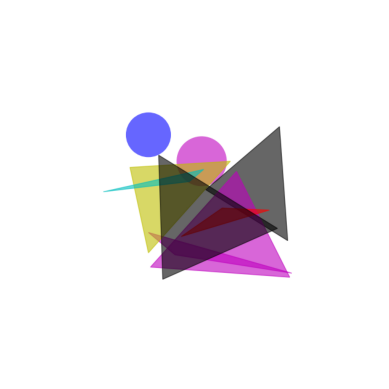

 Hallucinated 2 rectangles (negative space?), missed 1 triangle


In [97]:
new_get_response("r0_c2_t7.png")

In [171]:
new_data = old_data.copy()
new_data

[{'pic_id': 'Format',
  'response': 'LLM given response',
  'score': "calculated score of LLM's response",
  'raw': 'list of tuples (response,true); ordered [rect,circ,tri]',
  'notes': 'notes'},
 {'pic_id': 'test',
  'response': "Here's a breakdown of the shapes in the image:\n\n*   **Circles:** There are 3 circles (blue, yellow, and turquoise).\n*   **Rectangle:** There is 1 rectangle (gray).\n\n**Total:** 4 shapes.\n",
  'score': 1,
  'raw': [(1, 1), (3, 3), (0, 0)],
  'notes': '1 rectangle, 3 circles; probably too simple composition'},
 {'pic_id': 'test2',
  'response': "Here's a breakdown of the shapes in the image and their counts:\n\n*   **Circles:** 4 (one gray, one yellow, one red, one blue)\n*   **Squares/Rectangles:** 6 (various colors)\n*   **Triangles:** 3 (one red inside a circle, two purple)\n\n**Total Shapes:** 13\n",
  'score': 0.8111,
  'raw': [(6, 5), (4, 4), (3, 5)],
  'notes': '5 rectangles, 4 circles, 5 triangles; hallucinated rectangle'},
 {'pic_id': 'r3_c5_t2',


In [175]:
new_row = {"pic_id": "r0_c2_t7",
            "response": """Here's a breakdown of the shapes in the image and their counts:

*   **Triangles:** 6
*   **Circles:** 2
*   **Rectangles/Parallelograms:** 2 (one is a long, thin rectangle)

So, in total, there are **10** shapes in the image.
""",
            "score": avg([(2,0),(2,2),(6,7)]),
            "raw": [(2,0),(2,2),(6,7)],
            "notes":" Hallucinated 2 rectangles (negative space?), missed 1 triangle",
           }

#new_data.append(new_row)

responses = pd.DataFrame(new_data)
responses

,pic_id,response,score,raw,notes
0,Format,LLM given response,calculated score of LLM's response,"list of tuples (response,true); ordered [rect,...",notes
1,test,Here's a breakdown of the shapes in the image:...,1,"[(1, 1), (3, 3), (0, 0)]","1 rectangle, 3 circles; probably too simple co..."
2,test2,Here's a breakdown of the shapes in the image ...,0.8111,"[(6, 5), (4, 4), (3, 5)]","5 rectangles, 4 circles, 5 triangles; hallucin..."
3,r3_c5_t2,Here's a breakdown of the shapes in the image ...,0.9333,"[(3, 3), (4, 5), (2, 2)]","Incorrect triangle color, Missed a circle, Inc..."
4,r0_c1_t5,Here's a breakdown of the shapes in the image ...,0.8125,"[(0, 0), (1, 1), (8, 5)]",May be counting subsections created by overlap...
5,r3_c2_t3,Here's a breakdown of the shapes identified in...,0.8889,"[(3, 3), (2, 3), (3, 3)]",Wrong number of circles
6,r2_c6_t0,Here's a breakdown of the shapes identified in...,0.8333,"[(3, 2), (6, 6), (0, 0)]",Incorrect number of rectangles
7,r4_c4_t3,Here's a breakdown of the shapes in the image ...,0.9167,"[(4, 4), (3, 4), (3, 3)]",Missed a circle
8,r8_c5_t1,Here's a breakdown of the shapes in the image ...,0.6944,"[(6, 8), (5, 6), (2, 1)]",counting 'line' as rectangle in score
9,r4_c6_t4,Here's a breakdown of the shapes in the image ...,0.7222,"[(3, 4), (4, 6), (3, 4)]",Wrong on all counts


In [181]:
test_list = ["r1_c8_t0.png","r2_c8_t4.png"]

Here's a breakdown of the shapes in the image and their counts:

*   **Circles:** 8
*   **Square:** 1

So, there are a total of **9** shapes in the image.


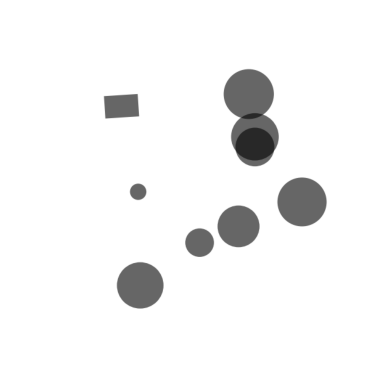

 Correct; b&w


AttributeError: 'tuple' object has no attribute 'keys'

In [183]:
for pic in test_list:
    new_get_response(pic)

In [189]:
r1_c8_t0 = new_data[-1]

new_data[-1]= r1_c8_t0[0]

new_data[-1]

{'pic_id': 'r1_c8_t0.png',
 'response': "Here's a breakdown of the shapes in the image and their counts:\n\n*   **Circles:** 8\n*   **Square:** 1\n\nSo, there are a total of **9** shapes in the image.",
 'score': None,
 'raw': None,
 'notes': 'Correct; b&w'}

In [203]:
new_data[-1]["pic_id"] = "r1_c8_t0"

new_data[-1]

{'pic_id': 'r1_c8_t0',
 'response': "Here's a breakdown of the shapes in the image and their counts:\n\n*   **Circles:** 8\n*   **Square:** 1\n\nSo, there are a total of **9** shapes in the image.",
 'score': None,
 'raw': None,
 'notes': 'Correct; b&w'}

In [205]:
responses = pd.DataFrame(new_data)
responses.tail()

,pic_id,response,score,raw,notes
8,r8_c5_t1,Here's a breakdown of the shapes in the image ...,0.6944,"[(6, 8), (5, 6), (2, 1)]",counting 'line' as rectangle in score
9,r4_c6_t4,Here's a breakdown of the shapes in the image ...,0.7222,"[(3, 4), (4, 6), (3, 4)]",Wrong on all counts
10,r6_c6_t0,Here's a breakdown of the shapes in the image ...,0.9,"[(6, 6), (4, 5), (0, 0)]","image labelled incorrectly, there are 5 circle..."
11,r0_c2_t7,Here's a breakdown of the shapes in the image ...,0.619,"[(2, 0), (2, 2), (6, 7)]","Hallucinated 2 rectangles (negative space?), ..."
12,r1_c8_t0,Here's a breakdown of the shapes in the image ...,None,None,Correct; b&w


In [209]:
os.listdir(data_dir)

['r4_c7_t5.png',
 'r0_c8_t5.png',
 'r4_c7_t4.png',
 'r8_c3_t3.png',
 'r0_c6_t3.png',
 'r8_c1_t2.png',
 '.DS_Store',
 'r4_c7_t1.png',
 'r2_c1_t3.png',
 'r1_c4_t6.png',
 'r3_c7_t7.png',
 'r7_c6_t3.png',
 'r7_c6_t2.png',
 'r5_c5_t4.png',
 'r4_c4_t2.png',
 'r2_c8_t4.png',
 'r4_c6_t4.png',
 'r3_c2_t5.png',
 'r2_c6_t2.png',
 'r3_c0_t4.png',
 'r6_c7_t2.png',
 'r2_c4_t2.png',
 'r4_c4_t5.png',
 'r8_c0_t3.png',
 'r4_c6_t2.png',
 'r7_c1_t2.png',
 'r0_c3_t4.png',
 'r2_c2_t7.png',
 'r3_c4_t4.png',
 'r5_c8_t3.png',
 'r0_c3_t7.png',
 'r5_c4_t0.png',
 'r2_c2_t5.png',
 'r5_c6_t1.png',
 'r5_c4_t5.png',
 'Used',
 'r2_c0_t7.png',
 'r8_c4_t4.png',
 'r4_c2_t5.png',
 'r7_c7_t0.png']

In [213]:
test_list = ['r4_c7_t5.png',
 'r0_c8_t5.png']

Here's a breakdown of the shapes in the image and their counts:

*   **Circles:** 6
*   **Triangles:** 4
*   **Rectangles:** 4
*   **Lines:** 1

**Total Shapes:** 15


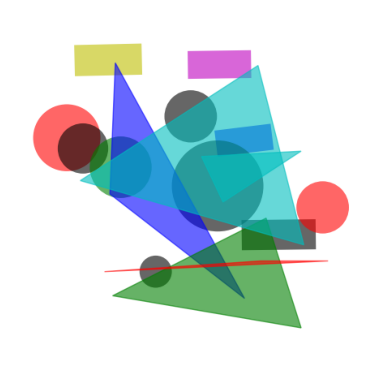

 "Line" = misidentified triangle; missed 1 circle


In [215]:
for pic in test_list:
    new_get_response(pic)
    test_list.remove(pic)

In [219]:
responses.tail()

,pic_id,response,score,raw,notes
8,r8_c5_t1,Here's a breakdown of the shapes in the image ...,0.6944,"[(6, 8), (5, 6), (2, 1)]",counting 'line' as rectangle in score
9,r4_c6_t4,Here's a breakdown of the shapes in the image ...,0.7222,"[(3, 4), (4, 6), (3, 4)]",Wrong on all counts
10,r6_c6_t0,Here's a breakdown of the shapes in the image ...,0.9,"[(6, 6), (4, 5), (0, 0)]","image labelled incorrectly, there are 5 circle..."
11,r0_c2_t7,Here's a breakdown of the shapes in the image ...,0.619,"[(2, 0), (2, 2), (6, 7)]","Hallucinated 2 rectangles (negative space?), ..."
12,r1_c8_t0,Here's a breakdown of the shapes in the image ...,None,None,Correct; b&w


In [221]:
new_data[-1]

{'pic_id': 'r4_c7_t5.',
 'response': "Here's a breakdown of the shapes in the image and their counts:\n\n*   **Circles:** 6\n*   **Triangles:** 4\n*   **Rectangles:** 4\n*   **Lines:** 1\n\n**Total Shapes:** 15",
 'score': None,
 'raw': None,
 'notes': '"Line" = misidentified triangle; missed 1 circle'}

Here's a breakdown of the shapes in the image and their counts:

*   **Circles:** 6
*   **Triangles:** 3
*   **Squares/Rectangles:** 3
*   **Lines:** 5

It's worth noting that the shapes are overlapping and have varying transparency, which can make precise counting a bit subjective.


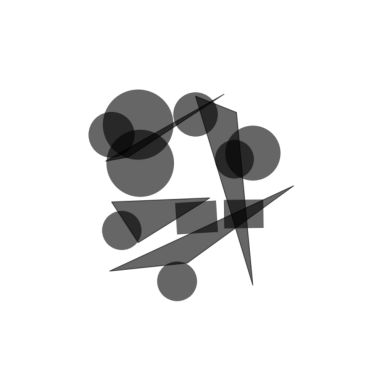

 Hallucinated 1 rectangle, 2 missed circles, 1 missed triangle, 5 hallucinated lines?


In [227]:
responses = new_get_response("r2_c8_t4.png")

In [235]:
responses.tail()

,pic_id,response,score,raw,notes
11,r0_c2_t7,Here's a breakdown of the shapes in the image ...,0.619,"[(2, 0), (2, 2), (6, 7)]","Hallucinated 2 rectangles (negative space?), ..."
12,r1_c8_t0,Here's a breakdown of the shapes in the image ...,None,None,Correct; b&w
13,r4_c7_t5.,Here's a breakdown of the shapes in the image ...,None,None,"""Line"" = misidentified triangle; missed 1 circle"
14,r2_c8_t4,Here's a breakdown of the shapes in the image ...,None,None,"Hallucinated 1 rectangle, 2 missed circles, 1 ..."
15,r0_c6_t3,Here's a breakdown of the shapes in the image ...,None,None,"1 hallucinated ""rectangle"", 1 missed circle"


Here's a breakdown of the shapes in the image and their counts:

*   **Triangles:** 3
*   **Circles:** 5
*   **Quadrilaterals (specifically, a parallelogram/trapezoid):** 1

So, in total, there are **9** shapes in the image.


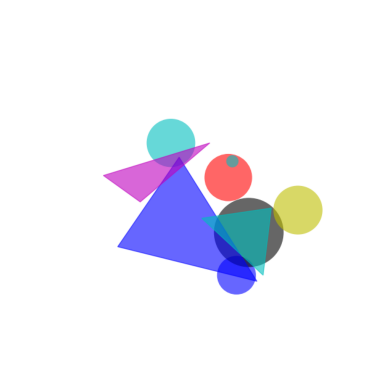

 1 hallucinated "rectangle", 1 missed circle


In [233]:
responses = new_get_response("r0_c6_t3.png")

In [237]:
!cd Data && ls

Used         r2_c1_t3.png r3_c2_t5.png r4_c6_t2.png r5_c5_t4.png r7_c6_t3.png
r0_c3_t4.png r2_c2_t5.png r3_c4_t4.png r4_c6_t4.png r5_c6_t1.png r7_c7_t0.png
r0_c3_t7.png r2_c2_t7.png r3_c7_t7.png r4_c7_t1.png r5_c8_t3.png r8_c0_t3.png
r0_c8_t5.png r2_c4_t2.png r4_c2_t5.png r4_c7_t4.png r6_c7_t2.png r8_c1_t2.png
r1_c4_t6.png r2_c6_t2.png r4_c4_t2.png r5_c4_t0.png r7_c1_t2.png r8_c3_t3.png
r2_c0_t7.png r3_c0_t4.png r4_c4_t5.png r5_c4_t5.png r7_c6_t2.png r8_c4_t4.png


In [241]:
multiple_pics = "r2_c1_t3.png r3_c2_t5.png r4_c6_t2.png".split(" ")
multiple_pics

['r2_c1_t3.png', 'r3_c2_t5.png', 'r4_c6_t2.png']

Here's a breakdown of the shapes in the image and their counts:

*   **Triangles:** There are 6 triangles visible.
*   **Squares/Rectangles:** There are 3 squares/rectangles visible.
*   **Circles:** There is 1 circle visible.

**Total:** 10 shapes.

It's worth noting that due to the overlapping and transparency, it can be a bit subjective to definitively count some shapes.


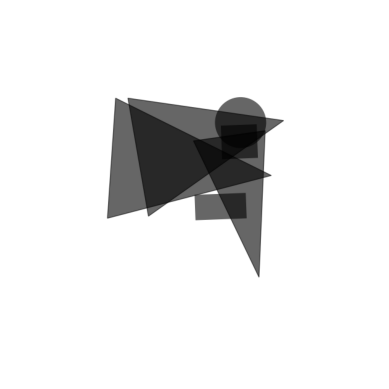

 3 hallucinated triangles, 1 hallucinated rectangle


Here's a breakdown of the shapes in the image and their counts:

*   **Circles:** 7 (Green, Yellow, Light Blue, Dark Blue, Purple, Black, and a smaller circle within the green one)
*   **Triangles:** 1 (Red)
*   **Rectangles:** 4 (Yellow, Light Blue, Green, and a smaller rectangle)

**Total Shapes:** 12


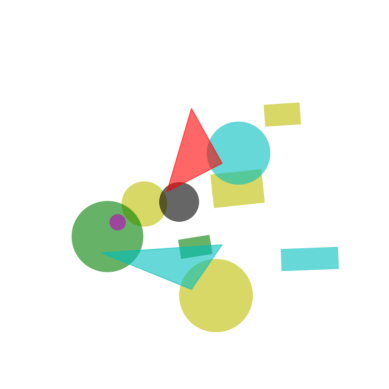

 1 hallucinated circle, missed 1 triangle


In [243]:
for pic in multiple_pics:
    responses=new_get_response(pic)
    multiple_pics.remove(pic)

In [255]:
data_list = os.listdir(data_dir)
data_list

['r0_c8_t5.png',
 'r4_c7_t4.png',
 'r8_c3_t3.png',
 'r8_c1_t2.png',
 '.DS_Store',
 'r4_c7_t1.png',
 'r1_c4_t6.png',
 'r3_c7_t7.png',
 'r7_c6_t3.png',
 'r7_c6_t2.png',
 'r5_c5_t4.png',
 'r4_c4_t2.png',
 'r4_c6_t4.png',
 'r3_c2_t5.png',
 'r2_c6_t2.png',
 'r3_c0_t4.png',
 'r6_c7_t2.png',
 'r2_c4_t2.png',
 'r4_c4_t5.png',
 'r8_c0_t3.png',
 'r7_c1_t2.png',
 'r0_c3_t4.png',
 'r2_c2_t7.png',
 'r3_c4_t4.png',
 'r5_c8_t3.png',
 'r0_c3_t7.png',
 'r5_c4_t0.png',
 'r2_c2_t5.png',
 'r5_c6_t1.png',
 'r5_c4_t5.png',
 'Used',
 'r2_c0_t7.png',
 'r8_c4_t4.png',
 'r4_c2_t5.png',
 'r7_c7_t0.png']

In [257]:
cleaned_list = []
for pic in data_list:
    if pic[-4:] == ".png":
        cleaned_list.append(pic)

cleaned_list

['r0_c8_t5.png',
 'r4_c7_t4.png',
 'r8_c3_t3.png',
 'r8_c1_t2.png',
 'r4_c7_t1.png',
 'r1_c4_t6.png',
 'r3_c7_t7.png',
 'r7_c6_t3.png',
 'r7_c6_t2.png',
 'r5_c5_t4.png',
 'r4_c4_t2.png',
 'r4_c6_t4.png',
 'r3_c2_t5.png',
 'r2_c6_t2.png',
 'r3_c0_t4.png',
 'r6_c7_t2.png',
 'r2_c4_t2.png',
 'r4_c4_t5.png',
 'r8_c0_t3.png',
 'r7_c1_t2.png',
 'r0_c3_t4.png',
 'r2_c2_t7.png',
 'r3_c4_t4.png',
 'r5_c8_t3.png',
 'r0_c3_t7.png',
 'r5_c4_t0.png',
 'r2_c2_t5.png',
 'r5_c6_t1.png',
 'r5_c4_t5.png',
 'r2_c0_t7.png',
 'r8_c4_t4.png',
 'r4_c2_t5.png',
 'r7_c7_t0.png']

In [259]:
len(cleaned_list)

33

r0_c8_t5 

Here's a breakdown of the shapes in the image and their counts:

*   **Triangles:** 5 (including the large blue triangle and smaller red/purple triangles)
*   **Circles:** 7 (various sizes and colors)
*   **Rectangles/Parallelograms:** 3 (the dark gray and purple shapes)
*   **Lines/Line Segments:** Numerous (difficult to count precisely due to overlapping, but there are many)

**Total:** There are at least 15 distinct shapes, but the number of line segments is very high.


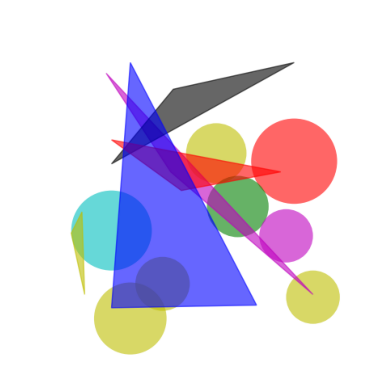

 Missed 1 circle, hallucinated 3 rectangles & "numerous" lines?





r4_c7_t4 

Here's a breakdown of the shapes in the image and their counts:

*   **Circles:** 4
*   **Triangles:** 6
*   **Rectangles/Squares:** 2 (one is a square, the other is a rectangle)

So, in total, there are **12** shapes in the image.


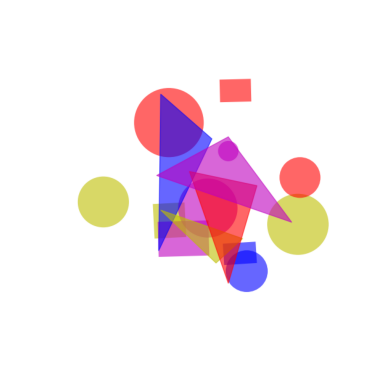

 missed 2 rectangles & 3 circles, hallucinated 2 triangles





r8_c3_t3 

Here's a breakdown of the shapes in the image and their counts:

*   **Triangles:** 3
*   **Circles:** 3
*   **Rectangles:** 5

So, in total, there are **11** shapes in the image.


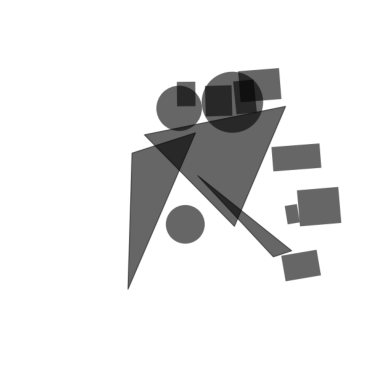

 Missed 3 rectangles





r8_c1_t2 

Here's a breakdown of the shapes in the image and their counts:

*   **Rectangles:** 6
*   **Triangles:** 2
*   **Circles:** 1
*   **Lines:** 1

**Total Shapes:** 10


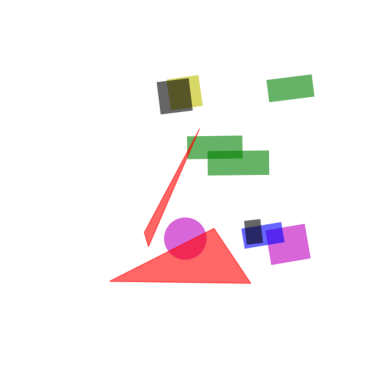

 Missed 2 rectangles, hallucinated "line" 





r4_c7_t1 

Here's a breakdown of the shapes in the image and their counts:

*   **Circles:** 6
*   **Triangles:** 1
*   **Squares/Rectangles:** 4

So, in total, there are **11** shapes in the image.


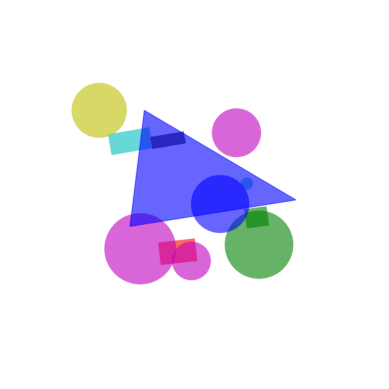

 Missed 1 circle


In [267]:
for pic in cleaned_list[:5]:
    print(pic[:-4],"\n")
    try:
        responses=new_get_response(pic)
    except FileNotFoundError:
        pass
    print("\n\n")

In [281]:
responses.loc[20,"notes"] = "Missed 3 rectangles; b&w"

In [283]:
responses.tail()

,pic_id,response,score,raw,notes
18,r0_c8_t5,Here's a breakdown of the shapes in the image ...,None,None,"Missed 1 circle, hallucinated 3 rectangles & ""..."
19,r4_c7_t4,Here's a breakdown of the shapes in the image ...,None,None,"missed 2 rectangles & 3 circles, hallucinated ..."
20,r8_c3_t3,Here's a breakdown of the shapes in the image ...,None,None,Missed 3 rectangles; b&w
21,r8_c1_t2,Here's a breakdown of the shapes in the image ...,None,None,"Missed 2 rectangles, hallucinated ""line"""
22,r4_c7_t1,Here's a breakdown of the shapes in the image ...,None,None,Missed 1 circle


In [277]:
df=responses.copy()

In [285]:
df.head()

,pic_id,response,score,raw,notes
0,Format,LLM given response,calculated score of LLM's response,"list of tuples (response,true); ordered [rect,...",notes
1,test,Here's a breakdown of the shapes in the image:...,1,"[(1, 1), (3, 3), (0, 0)]","1 rectangle, 3 circles; probably too simple co..."
2,test2,Here's a breakdown of the shapes in the image ...,0.8111,"[(6, 5), (4, 4), (3, 5)]","5 rectangles, 4 circles, 5 triangles; hallucin..."
3,r3_c5_t2,Here's a breakdown of the shapes in the image ...,0.9333,"[(3, 3), (4, 5), (2, 2)]","Incorrect triangle color, Missed a circle, Inc..."
4,r0_c1_t5,Here's a breakdown of the shapes in the image ...,0.8125,"[(0, 0), (1, 1), (8, 5)]",May be counting subsections created by overlap...
